In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder

# from utilsforecast.plotting import plot_series 
# from utilsforecast.evaluation import evaluate 
# from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


In [2]:
bookvisits = "/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv"
df_bv = pd.read_csv(bookvisits)

In [3]:
df = df_bv.set_index("show_date")
df

,book_theater_id,audience_count
show_date,,
2023-01-13,book_00001,50
2023-01-14,book_00001,64
2023-01-15,book_00001,58
2023-01-16,book_00001,44
2023-01-18,book_00001,12
...,...,...
2024-02-23,book_00829,16
2024-02-24,book_00829,8
2024-02-25,book_00829,16


In [4]:
# Date range in book theaters 
filtered_df = df[df['book_theater_id'] == "book_00001"]
min_date = filtered_df.index.min()
max_date = filtered_df.index.max()

print(f"Date range: {min_date} to {max_date}")

Date range: 2023-01-13 to 2024-02-28


In [5]:
df.index = pd.to_datetime(df.index)

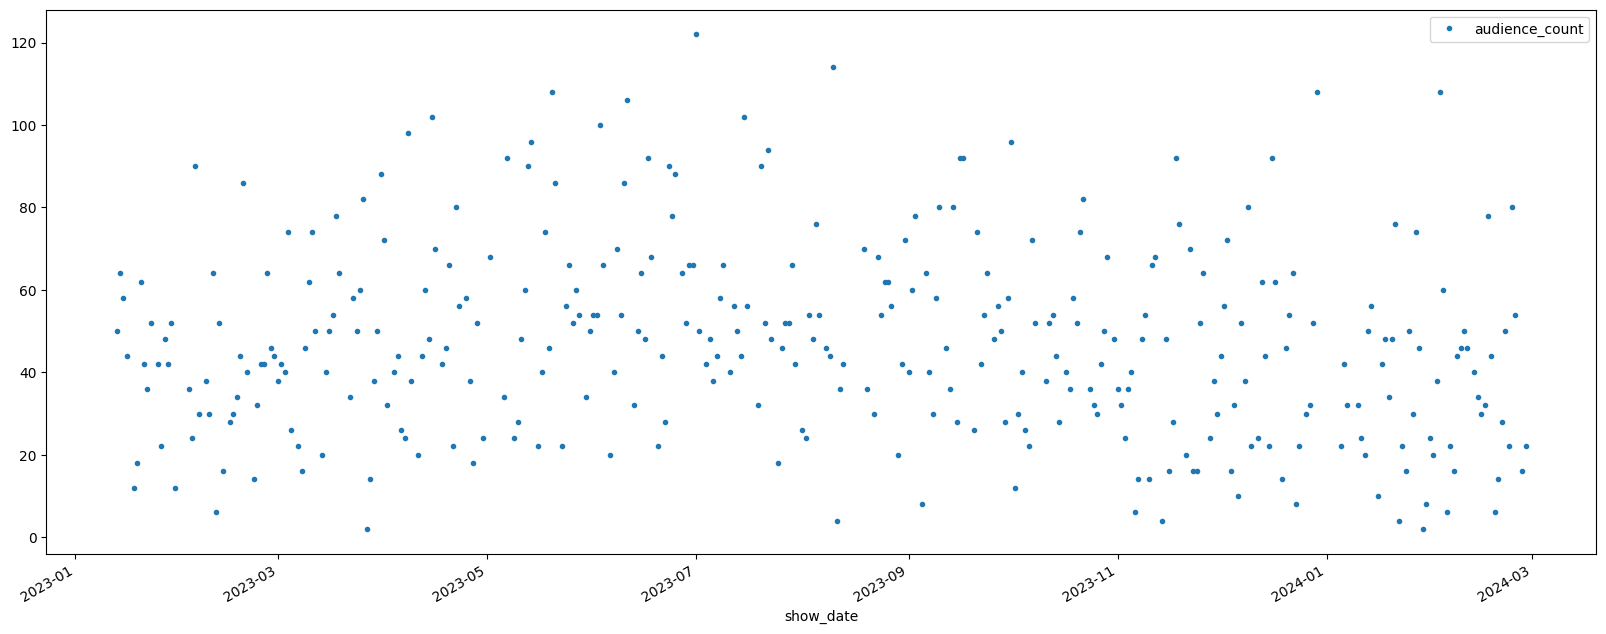

In [6]:
# Range of Traget values for theater id book_0001
df[df.book_theater_id=="book_00001"].plot(style='.',figsize=(20,8) )
plt.show()

In [7]:
df.dtypes

book_theater_id    object
audience_count      int64
dtype: object

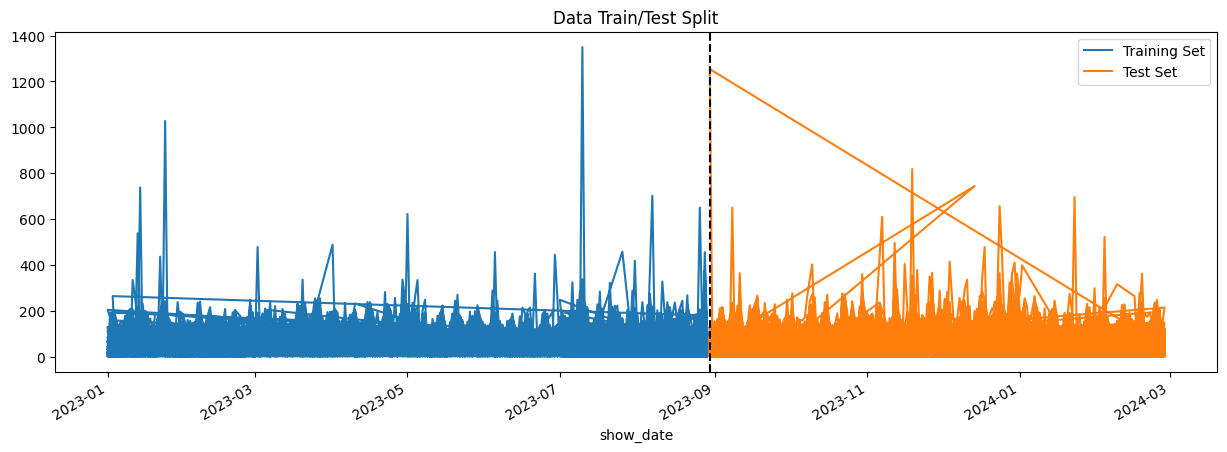

In [8]:
train = df.loc[df.index < '2023-08-30']
test = df.loc[df.index >= '2023-08-30']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2023-08-30', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [9]:
#Featuring show_date column 
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
   # df['hour'] = df.index.hour
    df['day'] = df.index.day_name()
    # df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [10]:
df = df.drop('year',axis=1)

In [11]:
df.nunique()

book_theater_id    826
audience_count     191
day                  7
month               12
dayofweek            7
is_weekend           2
dayofyear          365
dayofmonth          31
weekofyear          52
dtype: int64

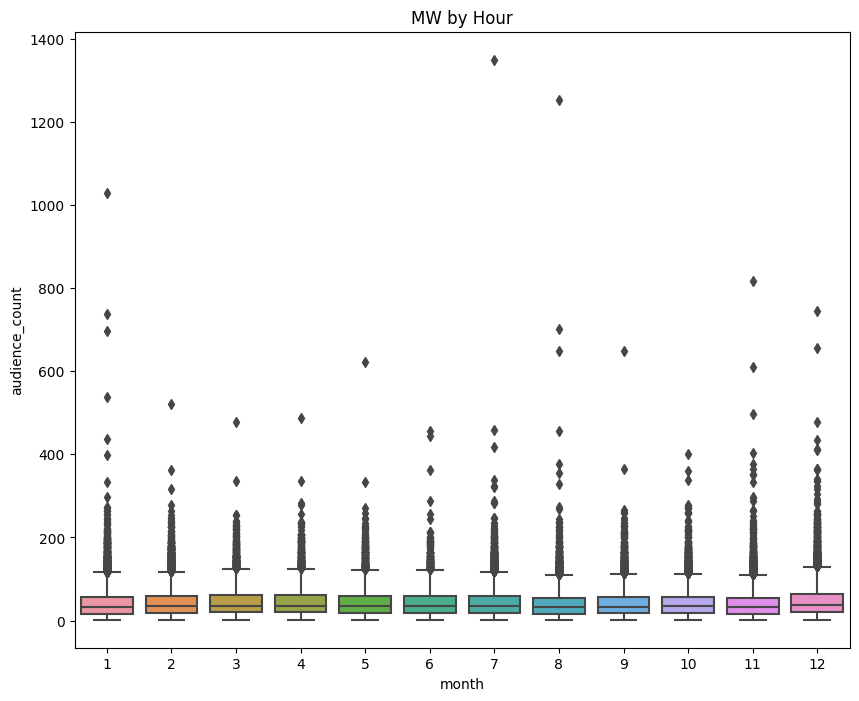

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='audience_count')
ax.set_title('MW by Hour')
plt.show()

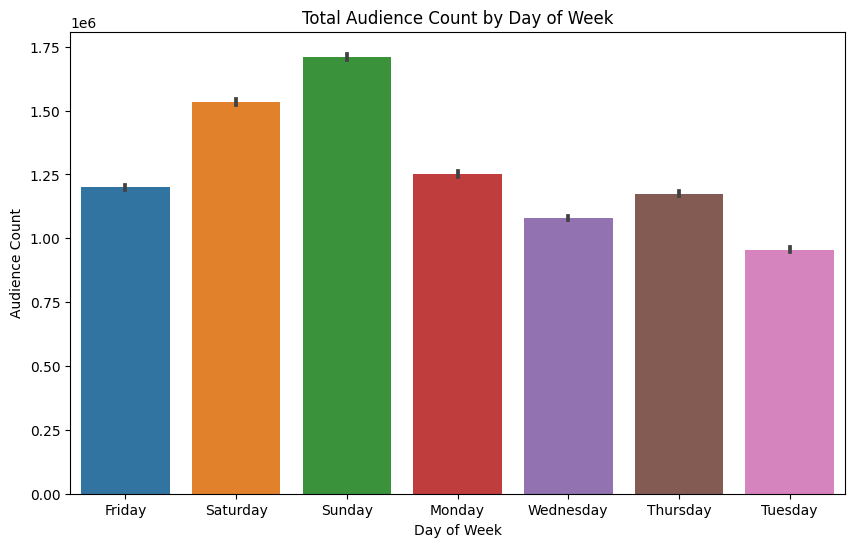

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=df,
    x='day',                 # column with day names
    y='audience_count',      # target
    estimator=sum            # sum audience per day
)

ax.set_title('Total Audience Count by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Audience Count')

plt.show()

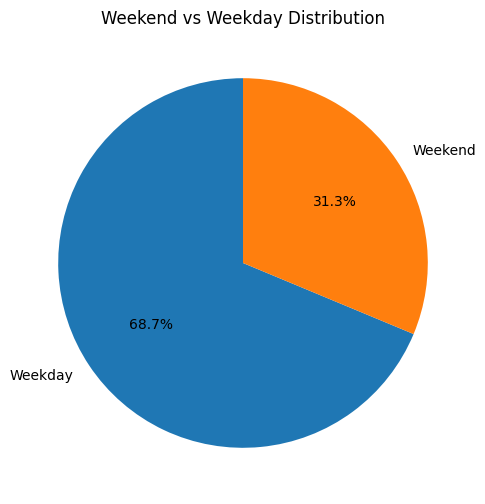

In [14]:
weekend_counts = df['is_weekend'].value_counts()

labels = ['Weekday', 'Weekend']  # assuming 0 = weekday, 1 = weekend

plt.figure(figsize=(6, 6))
plt.pie(weekend_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Weekend vs Weekday Distribution')
plt.show()

In [15]:
df_encoded = pd.get_dummies(df, columns=['day'])


bool_cols = df_encoded.select_dtypes(bool).columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
df_encoded

,book_theater_id,audience_count,month,dayofweek,is_weekend,dayofyear,dayofmonth,weekofyear,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
show_date,,,,,,,,,,,,,,,
2023-01-13,book_00001,50,1,4,0,13,13,2,1,0,0,0,0,0,0
2023-01-14,book_00001,64,1,5,1,14,14,2,0,0,1,0,0,0,0
2023-01-15,book_00001,58,1,6,1,15,15,2,0,0,0,1,0,0,0
2023-01-16,book_00001,44,1,0,0,16,16,3,0,1,0,0,0,0,0
2023-01-18,book_00001,12,1,2,0,18,18,3,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-23,book_00829,16,2,4,0,54,23,8,1,0,0,0,0,0,0
2024-02-24,book_00829,8,2,5,1,55,24,8,0,0,1,0,0,0,0
2024-02-25,book_00829,16,2,6,1,56,25,8,0,0,0,1,0,0,0


# Adding holidays as it affects People free time

In [16]:

import holidays

df_encoded['show_date'] = pd.to_datetime(df_encoded.index)

# Initialize India holidays
holiday = holidays.India(years=df_encoded['show_date'].dt.year.unique())

# Create a new column marking holidays
df_encoded['is_holiday'] = df_encoded['show_date'].isin(holiday)

In [17]:
book_theaters = "/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv"
book_th = pd.read_csv(book_theaters)
book_th

,book_theater_id,theater_type,theater_area,latitude,longitude
0,book_00093,Drama,Area_001,22.619233,78.113017
1,book_00078,Drama,Area_001,22.619233,78.113017
2,book_00291,Drama,Area_001,22.619233,78.113017
3,book_00258,Drama,Area_001,22.619233,78.113017
4,book_00212,Drama,Area_002,23.004410,79.934515
...,...,...,...,...,...
824,NaN,Drama,Area_006,23.005894,79.915496
825,NaN,Action,Area_006,23.005894,79.915496
826,book_00305,Action,Area_006,23.005894,79.915496
827,book_00216,Comedy,Area_016,25.963367,80.570258


In [18]:
#merge book_th dataset to add more columns  
merged_df = pd.merge(
    df_encoded,
    book_th[['book_theater_id', 'theater_area', 'theater_type']],
    on='book_theater_id',
    how='left'  # keeps all rows from book_visits, unmatched ones get NaN
)

# View result
merged_df

,book_theater_id,audience_count,month,dayofweek,is_weekend,dayofyear,dayofmonth,weekofyear,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,show_date,is_holiday,theater_area,theater_type
0,book_00001,50,1,4,0,13,13,2,1,0,0,0,0,0,0,2023-01-13,False,Area_002,Drama
1,book_00001,64,1,5,1,14,14,2,0,0,1,0,0,0,0,2023-01-14,False,Area_002,Drama
2,book_00001,58,1,6,1,15,15,2,0,0,0,1,0,0,0,2023-01-15,False,Area_002,Drama
3,book_00001,44,1,0,0,16,16,3,0,1,0,0,0,0,0,2023-01-16,False,Area_002,Drama
4,book_00001,12,1,2,0,18,18,3,0,0,0,0,0,0,1,2023-01-18,False,Area_002,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214041,book_00829,16,2,4,0,54,23,8,1,0,0,0,0,0,0,2024-02-23,False,NaN,NaN
214042,book_00829,8,2,5,1,55,24,8,0,0,1,0,0,0,0,2024-02-24,False,NaN,NaN
214043,book_00829,16,2,6,1,56,25,8,0,0,0,1,0,0,0,2024-02-25,False,NaN,NaN
214044,book_00829,16,2,1,0,58,27,9,0,0,0,0,0,1,0,2024-02-27,False,NaN,NaN


In [19]:

#remove null value in theater_type by mod value 
mode_value = merged_df['theater_type'].mode()[0]  
merged_df['theater_type'] = merged_df['theater_type'].fillna(mode_value)

merged_df

,book_theater_id,audience_count,month,dayofweek,is_weekend,dayofyear,dayofmonth,weekofyear,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,show_date,is_holiday,theater_area,theater_type
0,book_00001,50,1,4,0,13,13,2,1,0,0,0,0,0,0,2023-01-13,False,Area_002,Drama
1,book_00001,64,1,5,1,14,14,2,0,0,1,0,0,0,0,2023-01-14,False,Area_002,Drama
2,book_00001,58,1,6,1,15,15,2,0,0,0,1,0,0,0,2023-01-15,False,Area_002,Drama
3,book_00001,44,1,0,0,16,16,3,0,1,0,0,0,0,0,2023-01-16,False,Area_002,Drama
4,book_00001,12,1,2,0,18,18,3,0,0,0,0,0,0,1,2023-01-18,False,Area_002,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214041,book_00829,16,2,4,0,54,23,8,1,0,0,0,0,0,0,2024-02-23,False,NaN,Other
214042,book_00829,8,2,5,1,55,24,8,0,0,1,0,0,0,0,2024-02-24,False,NaN,Other
214043,book_00829,16,2,6,1,56,25,8,0,0,0,1,0,0,0,2024-02-25,False,NaN,Other
214044,book_00829,16,2,1,0,58,27,9,0,0,0,0,0,1,0,2024-02-27,False,NaN,Other


In [20]:
print(merged_df.isnull().sum(),merged_df.dtypes)


book_theater_id         0
audience_count          0
month                   0
dayofweek               0
is_weekend              0
dayofyear               0
dayofmonth              0
weekofyear              0
day_Friday              0
day_Monday              0
day_Saturday            0
day_Sunday              0
day_Thursday            0
day_Tuesday             0
day_Wednesday           0
show_date               0
is_holiday              0
theater_area       133896
theater_type            0
dtype: int64 book_theater_id            object
audience_count              int64
month                       int32
dayofweek                   int32
is_weekend                  int64
dayofyear                   int32
dayofmonth                  int32
weekofyear                 UInt32
day_Friday                  int64
day_Monday                  int64
day_Saturday                int64
day_Sunday                  int64
day_Thursday                int64
day_Tuesday                 int64
day_Wednesday    

In [21]:
#encoding theater_type values 

df_1 = pd.get_dummies(merged_df, columns=['theater_type'])

bool_cols = df_1.select_dtypes(bool).columns
df_1[bool_cols] = df_1[bool_cols].astype(int)

In [22]:
# #drop theater area columns as it have many null values 
df_1 = df_1.drop('theater_area',axis=1)

In [23]:
df_1

,book_theater_id,audience_count,month,dayofweek,is_weekend,dayofyear,dayofmonth,weekofyear,day_Friday,day_Monday,...,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,show_date,is_holiday,theater_type_Action,theater_type_Comedy,theater_type_Drama,theater_type_Other
0,book_00001,50,1,4,0,13,13,2,1,0,...,0,0,0,0,2023-01-13,0,0,0,1,0
1,book_00001,64,1,5,1,14,14,2,0,0,...,0,0,0,0,2023-01-14,0,0,0,1,0
2,book_00001,58,1,6,1,15,15,2,0,0,...,1,0,0,0,2023-01-15,0,0,0,1,0
3,book_00001,44,1,0,0,16,16,3,0,1,...,0,0,0,0,2023-01-16,0,0,0,1,0
4,book_00001,12,1,2,0,18,18,3,0,0,...,0,0,0,1,2023-01-18,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214041,book_00829,16,2,4,0,54,23,8,1,0,...,0,0,0,0,2024-02-23,0,0,0,0,1
214042,book_00829,8,2,5,1,55,24,8,0,0,...,0,0,0,0,2024-02-24,0,0,0,0,1
214043,book_00829,16,2,6,1,56,25,8,0,0,...,1,0,0,0,2024-02-25,0,0,0,0,1
214044,book_00829,16,2,1,0,58,27,9,0,0,...,0,0,1,0,2024-02-27,0,0,0,0,1


# Outliers Removal

<Axes: ylabel='Frequency'>

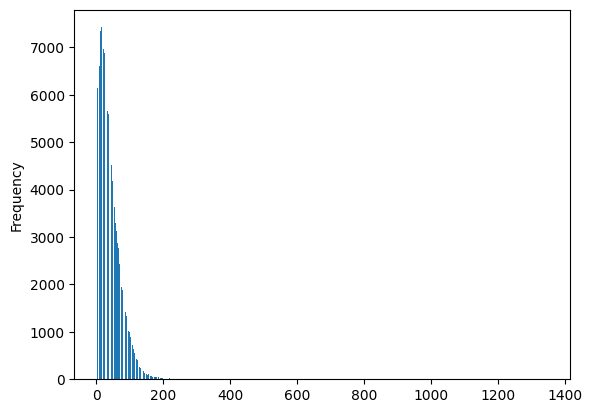

In [24]:
df_1["audience_count"].plot(kind="hist",bins=1000)

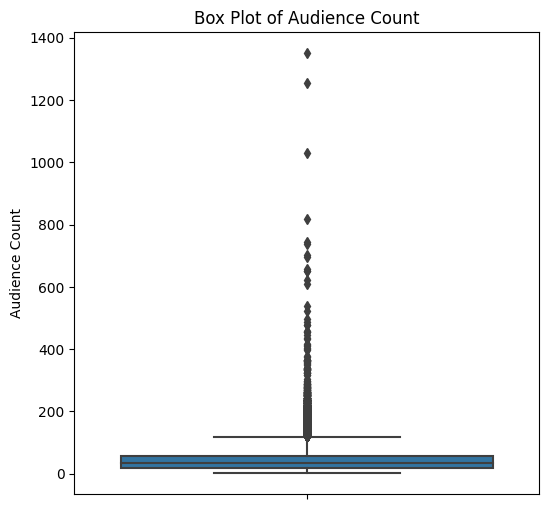

In [25]:
plt.figure(figsize=(6, 6))
sns.boxplot(y=df_1['audience_count'])
plt.title('Box Plot of Audience Count')
plt.ylabel('Audience Count')
plt.show()

In [26]:
print(df_1["audience_count"].mean())
print(df_1["audience_count"].max())


41.61656840118479
1350


In [27]:
len(df.query("audience_count < 4"))

4060

In [28]:
df_2 = df_1.query("audience_count <500").copy()
df_2.shape

(214031, 21)

In [29]:
df_2

,book_theater_id,audience_count,month,dayofweek,is_weekend,dayofyear,dayofmonth,weekofyear,day_Friday,day_Monday,...,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,show_date,is_holiday,theater_type_Action,theater_type_Comedy,theater_type_Drama,theater_type_Other
0,book_00001,50,1,4,0,13,13,2,1,0,...,0,0,0,0,2023-01-13,0,0,0,1,0
1,book_00001,64,1,5,1,14,14,2,0,0,...,0,0,0,0,2023-01-14,0,0,0,1,0
2,book_00001,58,1,6,1,15,15,2,0,0,...,1,0,0,0,2023-01-15,0,0,0,1,0
3,book_00001,44,1,0,0,16,16,3,0,1,...,0,0,0,0,2023-01-16,0,0,0,1,0
4,book_00001,12,1,2,0,18,18,3,0,0,...,0,0,0,1,2023-01-18,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214041,book_00829,16,2,4,0,54,23,8,1,0,...,0,0,0,0,2024-02-23,0,0,0,0,1
214042,book_00829,8,2,5,1,55,24,8,0,0,...,0,0,0,0,2024-02-24,0,0,0,0,1
214043,book_00829,16,2,6,1,56,25,8,0,0,...,1,0,0,0,2024-02-25,0,0,0,0,1
214044,book_00829,16,2,1,0,58,27,9,0,0,...,0,0,1,0,2024-02-27,0,0,0,0,1


# Adding Lag features 

In [30]:
df_2['lag_4week'] = df_2.groupby('book_theater_id')['audience_count'].shift(28)

df_2['lag_35'] = df_2.groupby('book_theater_id')['audience_count'].shift(35)



In [31]:
# apple1
first_month_mean = df_2.groupby('book_theater_id')['audience_count'].transform(
                      lambda x: x[:28].mean())
thirty5_mean = df_2.groupby('book_theater_id')['audience_count'].transform(
                     lambda x: x[:7].mean())




df_2['lag_4week'] = df_2['lag_4week'].fillna(first_month_mean)
df_2['lag_35'] = df_2['lag_35'].fillna(thirty5_mean)


In [32]:
df_2

,book_theater_id,audience_count,month,dayofweek,is_weekend,dayofyear,dayofmonth,weekofyear,day_Friday,day_Monday,...,day_Tuesday,day_Wednesday,show_date,is_holiday,theater_type_Action,theater_type_Comedy,theater_type_Drama,theater_type_Other,lag_4week,lag_35
0,book_00001,50,1,4,0,13,13,2,1,0,...,0,0,2023-01-13,0,0,0,1,0,39.285714,44.0
1,book_00001,64,1,5,1,14,14,2,0,0,...,0,0,2023-01-14,0,0,0,1,0,39.285714,44.0
2,book_00001,58,1,6,1,15,15,2,0,0,...,0,0,2023-01-15,0,0,0,1,0,39.285714,44.0
3,book_00001,44,1,0,0,16,16,3,0,1,...,0,0,2023-01-16,0,0,0,1,0,39.285714,44.0
4,book_00001,12,1,2,0,18,18,3,0,0,...,0,1,2023-01-18,0,0,0,1,0,39.285714,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214041,book_00829,16,2,4,0,54,23,8,1,0,...,0,0,2024-02-23,0,0,0,0,1,16.000000,16.0
214042,book_00829,8,2,5,1,55,24,8,0,0,...,0,0,2024-02-24,0,0,0,0,1,16.000000,12.0
214043,book_00829,16,2,6,1,56,25,8,0,0,...,0,0,2024-02-25,0,0,0,0,1,12.000000,12.0
214044,book_00829,16,2,1,0,58,27,9,0,0,...,1,0,2024-02-27,0,0,0,0,1,12.000000,16.0


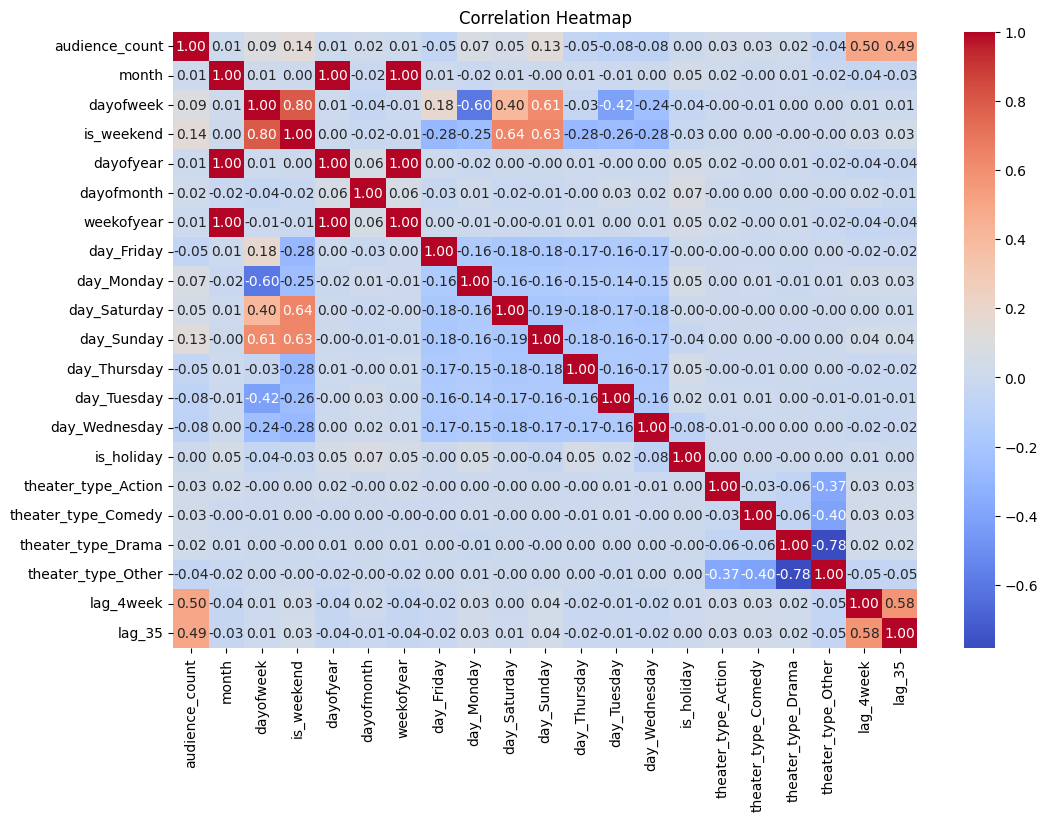

In [33]:

plt.figure(figsize=(12, 8))
corr = df_2.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

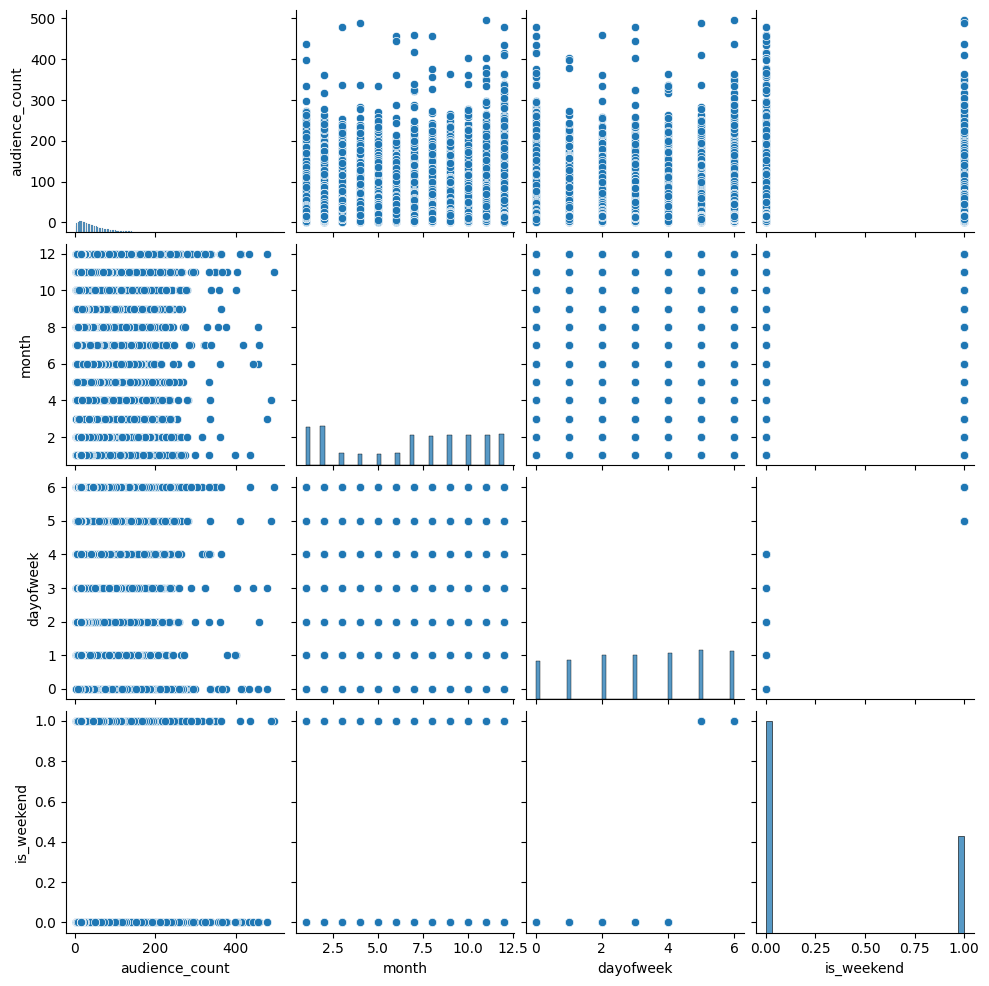

In [34]:
sns.pairplot(df_2, vars=['audience_count', 'month', 'dayofweek', 'is_weekend'])
plt.show()



# Data Split

In [35]:
train = df_2.loc[df_2.show_date < '2024-01-28']
test = df_2.loc[df_2.show_date >= '2024-01-28']

In [36]:
print(df_2.show_date.max())
print(df_2.show_date.min())

2024-02-28 00:00:00
2023-01-01 00:00:00


TargetEncoding object column book_theater_id

In [37]:
import category_encoders as ce

# Column to target-encode
cat_col = ['book_theater_id']

# Create encoder
encoder = ce.TargetEncoder(cols=cat_col)

# Fit encoder only on TRAIN data
train[cat_col] = encoder.fit_transform(train[cat_col], train['audience_count'])

# Transform TEST using same encoder
test[cat_col] = encoder.transform(test[cat_col])

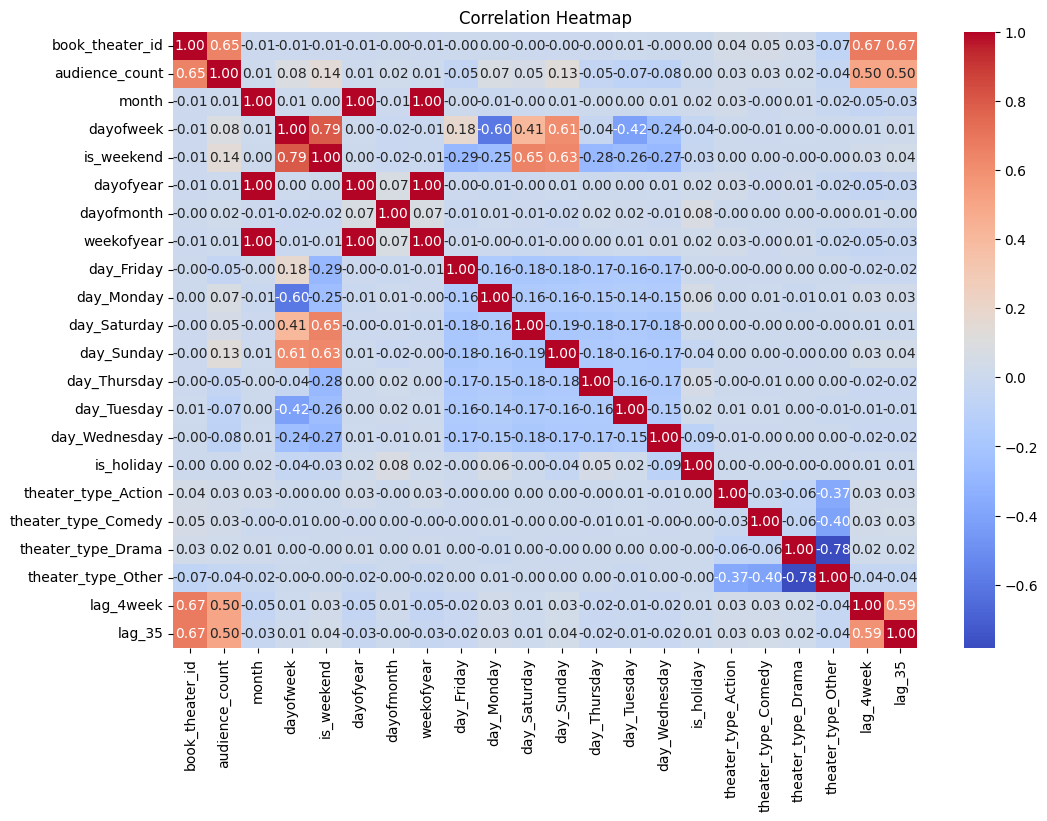

In [38]:

plt.figure(figsize=(12, 8))
corr = train.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [39]:
X_train= train.drop(columns = ["audience_count","show_date"])
y_train=train["audience_count"]
X_test= test.drop(columns = ["audience_count","show_date"])
y_test=test["audience_count"]


In [40]:
X_train

,book_theater_id,month,dayofweek,is_weekend,dayofyear,dayofmonth,weekofyear,day_Friday,day_Monday,day_Saturday,...,day_Thursday,day_Tuesday,day_Wednesday,is_holiday,theater_type_Action,theater_type_Comedy,theater_type_Drama,theater_type_Other,lag_4week,lag_35
0,48.102564,1,4,0,13,13,2,1,0,0,...,0,0,0,0,0,0,1,0,39.285714,44.0
1,48.102564,1,5,1,14,14,2,0,0,1,...,0,0,0,0,0,0,1,0,39.285714,44.0
2,48.102564,1,6,1,15,15,2,0,0,0,...,0,0,0,0,0,0,1,0,39.285714,44.0
3,48.102564,1,0,0,16,16,3,0,1,0,...,0,0,0,0,0,0,1,0,39.285714,44.0
4,48.102564,1,2,0,18,18,3,0,0,0,...,0,0,1,0,0,0,1,0,39.285714,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214014,10.993884,1,6,1,21,21,3,0,0,0,...,0,0,0,0,0,0,0,1,16.000000,8.0
214015,10.993884,1,1,0,23,23,4,0,0,0,...,0,1,0,0,0,0,0,1,12.000000,12.0
214016,10.993884,1,2,0,24,24,4,0,0,0,...,0,0,1,0,0,0,0,1,14.000000,12.0
214017,10.993884,1,3,0,25,25,4,0,0,0,...,1,0,0,0,0,0,0,1,12.000000,10.0


In [41]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score




# Model Fitting


Hperparameter tuning on xgb model 

In [42]:
# Base model
xgb_model = xgb.XGBRegressor(
    booster='gbtree',
    objective='reg:squarederror',
    early_stopping_rounds=100,
    base_score=0.1
)

# Parameter grid to tune
param_grid = {
    'n_estimators': [300, 700,1000],
    'learning_rate': [0.07, 0.1,0.15],
    'max_depth': [2, 5],
    
    'colsample_bytree': [0.8, 1.0],
    'subsample':[0.9],
}

# R2 scorer
scorer = make_scorer(r2_score)

# Grid search setup
grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=3,                  # 5-fold cross validation
    verbose=2,
    n_jobs=-1,
  
)

# Fit with early stopping eval_set
grid.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Best model and parameters
print("Best R2 Score:", grid.best_score_)
print("Best Params:", grid.best_params_)
best_model = grid.best_estimator_

fold_scores = [grid.cv_results_[f"split{i}_test_score"][grid.best_index_] for i in range(3)]
print("R2 Scores for Each Fold:", fold_scores)
print("Mean of Fold Scores:", np.mean(fold_scores))
print("Std Dev:", np.std(fold_scores))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best R2 Score: 0.48249593129779117
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.9}
R2 Scores for Each Fold: [0.42161323333906686, 0.4994087634121904, 0.5264657971421163]
Mean of Fold Scores: 0.48249593129779117
Std Dev: 0.0444450818547679


Final model fittinng

In [43]:
reg2 = xgb.XGBRegressor(base_score=0.2, booster='gbtree',    
                       n_estimators=500,
                    
                       early_stopping_rounds=500,
                       objective='reg:squarederror',
                       max_depth=5,
                       colsample_bytree = 0.8,
                       subsample=0.9,
                       learning_rate=0.1)
reg2.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=50)

[0]	validation_0-rmse:48.68552	validation_1-rmse:47.13452
[50]	validation_0-rmse:22.78865	validation_1-rmse:22.40494
[100]	validation_0-rmse:22.46841	validation_1-rmse:22.68228
[150]	validation_0-rmse:22.25724	validation_1-rmse:22.72251
[200]	validation_0-rmse:22.09611	validation_1-rmse:22.74704
[250]	validation_0-rmse:21.91665	validation_1-rmse:22.75161
[300]	validation_0-rmse:21.77826	validation_1-rmse:22.82414
[350]	validation_0-rmse:21.63442	validation_1-rmse:22.84131
[400]	validation_0-rmse:21.52384	validation_1-rmse:22.90697
[450]	validation_0-rmse:21.41469	validation_1-rmse:22.93820
[499]	validation_0-rmse:21.31437	validation_1-rmse:22.93870


XGBRegressor(base_score=0.2, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=500,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [44]:
y_prexg2 = reg2.predict(X_test)
from sklearn.metrics import r2_score
score1 =r2_score(y_test, y_prexg2)
score1

0.48666337977607255

In [45]:
print(reg2.score(X_train, y_train))

0.49384648579264434


In [46]:
best_model


XGBRegressor(base_score=0.1, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [47]:
best_model = grid.best_estimator_

y_best = best_model.predict(X_test)
from sklearn.metrics import r2_score
score1 =r2_score(y_test, y_best)
score1


0.4814769958840217

In [48]:
print(best_model.score(X_train, y_train))

0.48559562885932317


In [49]:
#LIghtGBM regression

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from lightgbm import LGBMRegressor


In [50]:
import warnings
warnings.filterwarnings('ignore')

Hyper parameter tuning on LGBM Regressor

In [51]:


models = {
  "lgb": LGBMRegressor(verbosity=-1),
}
params = {

    "lgb": {
    "learning_rate": [0.2,0.35],
    "num_leaves": [31],
 
    "max_depth": [2,3],
    "min_child_samples": [5,10],
    "subsample": [0.8,1.0],
    # "colsample_bytree": [0.7,1.0],
    
}
}

In [52]:
from sklearn.metrics import  mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import time



final_results = {}
for model_name in params:
  init_time = time.time()
  print(f"Tuning {model_name}")

  
    
  search = RandomizedSearchCV(
      estimator=models[model_name],
      param_distributions=params[model_name],
      n_iter=150,
      scoring='r2',
      cv=8,
      refit='r2',
      random_state=42,
      n_jobs=-1
  )  
  
  


  search.fit(X_train,y_train)

  models[model_name + " (tuned)"] = search.best_estimator_
  best_model = search.best_estimator_
  


  valid_pred = search.best_estimator_.predict(X_test)

  rmse_val = np.sqrt(mean_squared_error(y_test, valid_pred))
  r2_val = r2_score(y_test, valid_pred)
    
  time_taken = round(time.time() - init_time, 2)
  
  final_results[model_name] = {
        "Best Params": search.best_params_,
        "CV R2": round(search.best_score_, 4),
        "Test RMSE": round(rmse_val, 4),
        "Test R2": round(r2_val, 4),
        "Time": time_taken
    }

# Print all model results at once
for model, res in final_results.items():
    print(f"Model: {model}")
    print(res)
    print("="*50)

Tuning lgb
Model: lgb
{'Best Params': {'subsample': 0.8, 'num_leaves': 31, 'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.2}, 'CV R2': 0.4832, 'Test RMSE': 22.5305, 'Test R2': 0.4748, 'Time': 97.16}


In [53]:
#Final Fitting
lgb = LGBMRegressor(    
                       n_estimators=700,
                       num_leaves= 20,
                       min_child_samples= 10 , 
                       max_depth=2,
                       # colsample_bytree = 1,
                       random_state = 42,
                       subsample=0.8,
                       reg_alpha=0.9,
    
                    
                    
                       learning_rate=0.05)
lgb.fit(X_train,y_train)

LGBMRegressor(learning_rate=0.05, max_depth=2, min_child_samples=10,
              n_estimators=700, num_leaves=20, random_state=42, reg_alpha=0.9,
              subsample=0.8)

In [54]:

y_lgb = lgb.predict(X_test)
from sklearn.metrics import r2_score
score2 =r2_score(y_test, y_lgb) 
print(r2_score(y_test, y_lgb))

print(lgb.score(X_train, y_train))

0.4834724084818004
0.49470980788871133


In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.transform(X_test) 

In [56]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor(learning_rate=0.05, max_iter=50,max_depth=5,scoring='r2')
model.fit(X_train2,y_train)
y_hgb = model.predict(X_test2)
score3 = r2_score(y_test, y_hgb)
score3

0.48126995084278523

                           Model  r2_scores
0                        XGBoost   0.481477
1                  LGBMRegressor   0.483472
2  HistGradientBoostingRegressor   0.481270


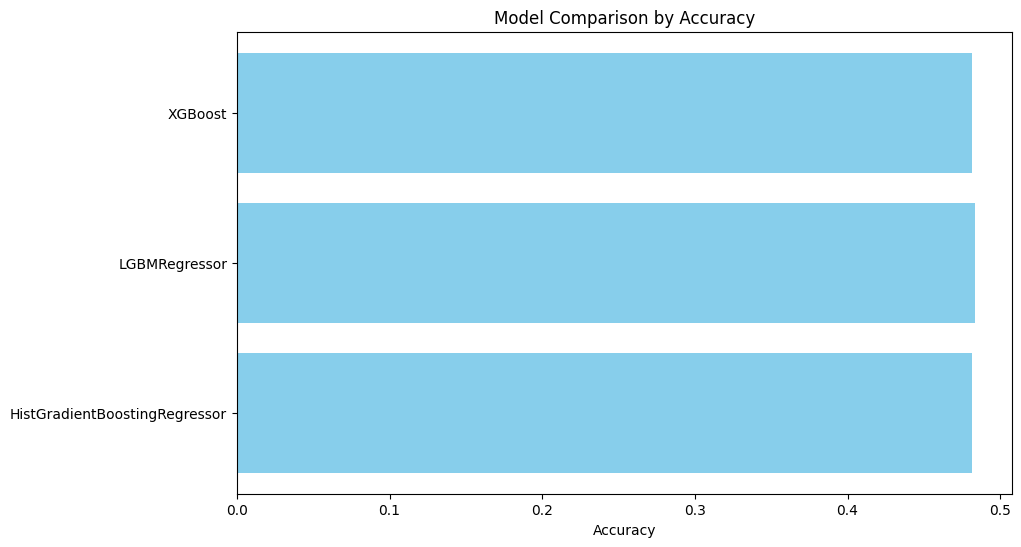

In [57]:
#Comparison model 
import matplotlib.pyplot as plt

#  Acurracy scores for each model
scores = [score1,score2,score3]
models = ['XGBoost',
          'LGBMRegressor',
          'HistGradientBoostingRegressor'
          
          
]
results_df = pd.DataFrame({
    'Model': models,
    'r2_scores': scores
})


print(results_df)

# Plot comparison
plt.figure(figsize=(10,6))
plt.barh(results_df['Model'], results_df['r2_scores'], color='skyblue')
plt.xlabel("Accuracy")
plt.title("Model Comparison by Accuracy")
plt.gca().invert_yaxis()  # highest accuracy at top
plt.show()

# Creating Submission dataset

In [58]:
sample_submission = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv")


In [59]:
sample_submission

,ID,audience_count
0,book_00001_2024-03-01,0
1,book_00001_2024-03-02,0
2,book_00001_2024-03-03,0
3,book_00001_2024-03-04,0
4,book_00001_2024-03-06,0
...,...,...
38057,book_00829_2024-04-18,0
38058,book_00829_2024-04-19,0
38059,book_00829_2024-04-20,0
38060,book_00829_2024-04-21,0


In [60]:
sub = '/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv'
df_sub = pd.read_csv(sub)

In [61]:
df_sub[['booking_id', 'date']] = df_sub['ID'].str.rsplit('_', n=1, expand=True)

In [62]:
df_sub

,ID,audience_count,booking_id,date
0,book_00001_2024-03-01,0,book_00001,2024-03-01
1,book_00001_2024-03-02,0,book_00001,2024-03-02
2,book_00001_2024-03-03,0,book_00001,2024-03-03
3,book_00001_2024-03-04,0,book_00001,2024-03-04
4,book_00001_2024-03-06,0,book_00001,2024-03-06
...,...,...,...,...
38057,book_00829_2024-04-18,0,book_00829,2024-04-18
38058,book_00829_2024-04-19,0,book_00829,2024-04-19
38059,book_00829_2024-04-20,0,book_00829,2024-04-20
38060,book_00829_2024-04-21,0,book_00829,2024-04-21


In [63]:
sub = df_sub.drop(columns=["ID"])

In [64]:
sub

,audience_count,booking_id,date
0,0,book_00001,2024-03-01
1,0,book_00001,2024-03-02
2,0,book_00001,2024-03-03
3,0,book_00001,2024-03-04
4,0,book_00001,2024-03-06
...,...,...,...
38057,0,book_00829,2024-04-18
38058,0,book_00829,2024-04-19
38059,0,book_00829,2024-04-20
38060,0,book_00829,2024-04-21


In [65]:
sub = sub.set_index('date')
sub.index = pd.to_datetime(sub.index)
print(sub.index.min(),"----",sub.index.max())


2024-03-01 00:00:00 ---- 2024-04-22 00:00:00


In [66]:
sub['show_date'] = pd.to_datetime(sub.index)

In [67]:
sub = sub.rename(columns={'booking_id': 'book_theater_id'})

In [68]:
sub

,audience_count,book_theater_id,show_date
date,,,
2024-03-01,0,book_00001,2024-03-01
2024-03-02,0,book_00001,2024-03-02
2024-03-03,0,book_00001,2024-03-03
2024-03-04,0,book_00001,2024-03-04
2024-03-06,0,book_00001,2024-03-06
...,...,...,...
2024-04-18,0,book_00829,2024-04-18
2024-04-19,0,book_00829,2024-04-19
2024-04-20,0,book_00829,2024-04-20


In [69]:
combined = pd.concat([df_2[['book_theater_id','show_date','audience_count']], 
                      sub[['book_theater_id','show_date']]])

combined = combined.sort_values(['book_theater_id','show_date'])

combined['lag_4week'] = combined.groupby('book_theater_id')['audience_count'].shift(28)
combined['lag_35'] = combined.groupby('book_theater_id')['audience_count'].shift(35)


sub = combined[combined['show_date'].isin(sub['show_date'])]

In [70]:
mean28 = sub.lag_4week.mean()
sub['lag_4week'] = sub['lag_4week'].fillna(mean28)
mean35 = sub.lag_35.mean()
sub['lag_35'] = sub['lag_35'].fillna(mean35)


In [71]:
sub

,book_theater_id,show_date,audience_count,lag_4week,lag_35
2024-03-01 00:00:00,book_00001,2024-03-01,NaN,8.00000,22.000000
2024-03-02 00:00:00,book_00001,2024-03-02,NaN,24.00000,16.000000
2024-03-03 00:00:00,book_00001,2024-03-03,NaN,20.00000,50.000000
2024-03-04 00:00:00,book_00001,2024-03-04,NaN,38.00000,30.000000
2024-03-06 00:00:00,book_00001,2024-03-06,NaN,108.00000,74.000000
...,...,...,...,...,...
2024-04-18 00:00:00,book_00829,2024-04-18,NaN,39.90467,39.807944
2024-04-19 00:00:00,book_00829,2024-04-19,NaN,39.90467,39.807944
2024-04-20 00:00:00,book_00829,2024-04-20,NaN,39.90467,39.807944
2024-04-21 00:00:00,book_00829,2024-04-21,NaN,39.90467,39.807944


In [72]:
sub.reset_index(inplace=True)

In [73]:
sub

,index,book_theater_id,show_date,audience_count,lag_4week,lag_35
0,2024-03-01,book_00001,2024-03-01,NaN,8.00000,22.000000
1,2024-03-02,book_00001,2024-03-02,NaN,24.00000,16.000000
2,2024-03-03,book_00001,2024-03-03,NaN,20.00000,50.000000
3,2024-03-04,book_00001,2024-03-04,NaN,38.00000,30.000000
4,2024-03-06,book_00001,2024-03-06,NaN,108.00000,74.000000
...,...,...,...,...,...,...
38057,2024-04-18,book_00829,2024-04-18,NaN,39.90467,39.807944
38058,2024-04-19,book_00829,2024-04-19,NaN,39.90467,39.807944
38059,2024-04-20,book_00829,2024-04-20,NaN,39.90467,39.807944
38060,2024-04-21,book_00829,2024-04-21,NaN,39.90467,39.807944


In [74]:
sub.reset_index().rename(columns={'index':'date'}, inplace=True)

sub = sub.set_index('index')

In [75]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
   # df['hour'] = df.index.hour
    df['day'] = df.index.day_name()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df


sub = create_features(sub)

In [76]:
sub = sub.drop('year',axis=1)

In [77]:
sub_encoded = pd.get_dummies(sub, columns=['day'])
bool_cols = sub_encoded.select_dtypes(bool).columns
sub_encoded[bool_cols] = sub_encoded[bool_cols].astype(int)
sub_encoded

,book_theater_id,show_date,audience_count,lag_4week,lag_35,quarter,month,dayofweek,is_weekend,dayofyear,dayofmonth,weekofyear,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
index,,,,,,,,,,,,,,,,,,,
2024-03-01,book_00001,2024-03-01,NaN,8.00000,22.000000,1,3,4,0,61,1,9,1,0,0,0,0,0,0
2024-03-02,book_00001,2024-03-02,NaN,24.00000,16.000000,1,3,5,1,62,2,9,0,0,1,0,0,0,0
2024-03-03,book_00001,2024-03-03,NaN,20.00000,50.000000,1,3,6,1,63,3,9,0,0,0,1,0,0,0
2024-03-04,book_00001,2024-03-04,NaN,38.00000,30.000000,1,3,0,0,64,4,10,0,1,0,0,0,0,0
2024-03-06,book_00001,2024-03-06,NaN,108.00000,74.000000,1,3,2,0,66,6,10,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-18,book_00829,2024-04-18,NaN,39.90467,39.807944,2,4,3,0,109,18,16,0,0,0,0,1,0,0
2024-04-19,book_00829,2024-04-19,NaN,39.90467,39.807944,2,4,4,0,110,19,16,1,0,0,0,0,0,0
2024-04-20,book_00829,2024-04-20,NaN,39.90467,39.807944,2,4,5,1,111,20,16,0,0,1,0,0,0,0


In [78]:


# Initialize India holidays
holiday = holidays.India(years=sub_encoded['show_date'].dt.year.unique())

# Create a new column marking holidays
sub_encoded['is_holiday'] = sub_encoded['show_date'].isin(holiday)

sub_encoded

,book_theater_id,show_date,audience_count,lag_4week,lag_35,quarter,month,dayofweek,is_weekend,dayofyear,dayofmonth,weekofyear,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,is_holiday
index,,,,,,,,,,,,,,,,,,,,
2024-03-01,book_00001,2024-03-01,NaN,8.00000,22.000000,1,3,4,0,61,1,9,1,0,0,0,0,0,0,False
2024-03-02,book_00001,2024-03-02,NaN,24.00000,16.000000,1,3,5,1,62,2,9,0,0,1,0,0,0,0,False
2024-03-03,book_00001,2024-03-03,NaN,20.00000,50.000000,1,3,6,1,63,3,9,0,0,0,1,0,0,0,False
2024-03-04,book_00001,2024-03-04,NaN,38.00000,30.000000,1,3,0,0,64,4,10,0,1,0,0,0,0,0,False
2024-03-06,book_00001,2024-03-06,NaN,108.00000,74.000000,1,3,2,0,66,6,10,0,0,0,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-18,book_00829,2024-04-18,NaN,39.90467,39.807944,2,4,3,0,109,18,16,0,0,0,0,1,0,0,False
2024-04-19,book_00829,2024-04-19,NaN,39.90467,39.807944,2,4,4,0,110,19,16,1,0,0,0,0,0,0,False
2024-04-20,book_00829,2024-04-20,NaN,39.90467,39.807944,2,4,5,1,111,20,16,0,0,1,0,0,0,0,False


In [79]:
#Sub mission dataset date range
print(sub_encoded.index.max())
print(sub_encoded.index.min())

2024-04-22 00:00:00
2024-03-01 00:00:00


In [80]:
sub_encoded = sub_encoded.rename(columns={'book_theater_id': 'booking_id'})

In [81]:
sub_merged = pd.merge(
    sub_encoded,
    book_th[['book_theater_id', 'theater_type']],
    left_on='booking_id',      # column name in sub_encoded
    right_on='book_theater_id',  # column name in book_th
    how='left'
)

sub_merged = sub_merged.drop("book_theater_id",axis=1)
sub_merged

,booking_id,show_date,audience_count,lag_4week,lag_35,quarter,month,dayofweek,is_weekend,dayofyear,...,weekofyear,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,is_holiday,theater_type
0,book_00001,2024-03-01,NaN,8.00000,22.000000,1,3,4,0,61,...,9,1,0,0,0,0,0,0,False,Drama
1,book_00001,2024-03-02,NaN,24.00000,16.000000,1,3,5,1,62,...,9,0,0,1,0,0,0,0,False,Drama
2,book_00001,2024-03-03,NaN,20.00000,50.000000,1,3,6,1,63,...,9,0,0,0,1,0,0,0,False,Drama
3,book_00001,2024-03-04,NaN,38.00000,30.000000,1,3,0,0,64,...,10,0,1,0,0,0,0,0,False,Drama
4,book_00001,2024-03-06,NaN,108.00000,74.000000,1,3,2,0,66,...,10,0,0,0,0,0,0,1,False,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38057,book_00829,2024-04-18,NaN,39.90467,39.807944,2,4,3,0,109,...,16,0,0,0,0,1,0,0,False,NaN
38058,book_00829,2024-04-19,NaN,39.90467,39.807944,2,4,4,0,110,...,16,1,0,0,0,0,0,0,False,NaN
38059,book_00829,2024-04-20,NaN,39.90467,39.807944,2,4,5,1,111,...,16,0,0,1,0,0,0,0,False,NaN
38060,book_00829,2024-04-21,NaN,39.90467,39.807944,2,4,6,1,112,...,16,0,0,0,1,0,0,0,True,NaN


In [82]:
sub_merged['theater_type'] = sub_merged['theater_type'].fillna(mode_value)
sub_merged

,booking_id,show_date,audience_count,lag_4week,lag_35,quarter,month,dayofweek,is_weekend,dayofyear,...,weekofyear,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,is_holiday,theater_type
0,book_00001,2024-03-01,NaN,8.00000,22.000000,1,3,4,0,61,...,9,1,0,0,0,0,0,0,False,Drama
1,book_00001,2024-03-02,NaN,24.00000,16.000000,1,3,5,1,62,...,9,0,0,1,0,0,0,0,False,Drama
2,book_00001,2024-03-03,NaN,20.00000,50.000000,1,3,6,1,63,...,9,0,0,0,1,0,0,0,False,Drama
3,book_00001,2024-03-04,NaN,38.00000,30.000000,1,3,0,0,64,...,10,0,1,0,0,0,0,0,False,Drama
4,book_00001,2024-03-06,NaN,108.00000,74.000000,1,3,2,0,66,...,10,0,0,0,0,0,0,1,False,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38057,book_00829,2024-04-18,NaN,39.90467,39.807944,2,4,3,0,109,...,16,0,0,0,0,1,0,0,False,Other
38058,book_00829,2024-04-19,NaN,39.90467,39.807944,2,4,4,0,110,...,16,1,0,0,0,0,0,0,False,Other
38059,book_00829,2024-04-20,NaN,39.90467,39.807944,2,4,5,1,111,...,16,0,0,1,0,0,0,0,False,Other
38060,book_00829,2024-04-21,NaN,39.90467,39.807944,2,4,6,1,112,...,16,0,0,0,1,0,0,0,True,Other


In [83]:
sub_merged = pd.get_dummies(sub_merged, columns=['theater_type'])

bool_cols = sub_merged.select_dtypes(bool).columns
sub_merged[bool_cols] = sub_merged[bool_cols].astype(int)

sub_merged = sub_merged.drop(columns= ["show_date"])

sub_merged

,booking_id,audience_count,lag_4week,lag_35,quarter,month,dayofweek,is_weekend,dayofyear,dayofmonth,...,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,is_holiday,theater_type_Action,theater_type_Comedy,theater_type_Drama,theater_type_Other
0,book_00001,NaN,8.00000,22.000000,1,3,4,0,61,1,...,0,0,0,0,0,0,0,0,1,0
1,book_00001,NaN,24.00000,16.000000,1,3,5,1,62,2,...,1,0,0,0,0,0,0,0,1,0
2,book_00001,NaN,20.00000,50.000000,1,3,6,1,63,3,...,0,1,0,0,0,0,0,0,1,0
3,book_00001,NaN,38.00000,30.000000,1,3,0,0,64,4,...,0,0,0,0,0,0,0,0,1,0
4,book_00001,NaN,108.00000,74.000000,1,3,2,0,66,6,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38057,book_00829,NaN,39.90467,39.807944,2,4,3,0,109,18,...,0,0,1,0,0,0,0,0,0,1
38058,book_00829,NaN,39.90467,39.807944,2,4,4,0,110,19,...,0,0,0,0,0,0,0,0,0,1
38059,book_00829,NaN,39.90467,39.807944,2,4,5,1,111,20,...,1,0,0,0,0,0,0,0,0,1
38060,book_00829,NaN,39.90467,39.807944,2,4,6,1,112,21,...,0,1,0,0,0,1,0,0,0,1


In [84]:
sample_submission = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv")
sample_submission

,ID,audience_count
0,book_00001_2024-03-01,0
1,book_00001_2024-03-02,0
2,book_00001_2024-03-03,0
3,book_00001_2024-03-04,0
4,book_00001_2024-03-06,0
...,...,...
38057,book_00829_2024-04-18,0
38058,book_00829_2024-04-19,0
38059,book_00829_2024-04-20,0
38060,book_00829_2024-04-21,0


In [85]:
sub1 = sub_merged.drop("audience_count",axis=1)

sub1 = sub1.rename(columns={'booking_id': 'book_theater_id'})

#sub1["book_theater_id"] = sub1["book_theater_id"].astype('category')

In [86]:
sub1

,book_theater_id,lag_4week,lag_35,quarter,month,dayofweek,is_weekend,dayofyear,dayofmonth,weekofyear,...,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,is_holiday,theater_type_Action,theater_type_Comedy,theater_type_Drama,theater_type_Other
0,book_00001,8.00000,22.000000,1,3,4,0,61,1,9,...,0,0,0,0,0,0,0,0,1,0
1,book_00001,24.00000,16.000000,1,3,5,1,62,2,9,...,1,0,0,0,0,0,0,0,1,0
2,book_00001,20.00000,50.000000,1,3,6,1,63,3,9,...,0,1,0,0,0,0,0,0,1,0
3,book_00001,38.00000,30.000000,1,3,0,0,64,4,10,...,0,0,0,0,0,0,0,0,1,0
4,book_00001,108.00000,74.000000,1,3,2,0,66,6,10,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38057,book_00829,39.90467,39.807944,2,4,3,0,109,18,16,...,0,0,1,0,0,0,0,0,0,1
38058,book_00829,39.90467,39.807944,2,4,4,0,110,19,16,...,0,0,0,0,0,0,0,0,0,1
38059,book_00829,39.90467,39.807944,2,4,5,1,111,20,16,...,1,0,0,0,0,0,0,0,0,1
38060,book_00829,39.90467,39.807944,2,4,6,1,112,21,16,...,0,1,0,0,0,1,0,0,0,1


In [87]:
sub1[cat_col] = encoder.transform(sub1[cat_col])

In [88]:
sub1 = sub1[X_train.columns]


In [89]:
sub1

,book_theater_id,month,dayofweek,is_weekend,dayofyear,dayofmonth,weekofyear,day_Friday,day_Monday,day_Saturday,...,day_Thursday,day_Tuesday,day_Wednesday,is_holiday,theater_type_Action,theater_type_Comedy,theater_type_Drama,theater_type_Other,lag_4week,lag_35
0,48.102564,3,4,0,61,1,9,1,0,0,...,0,0,0,0,0,0,1,0,8.00000,22.000000
1,48.102564,3,5,1,62,2,9,0,0,1,...,0,0,0,0,0,0,1,0,24.00000,16.000000
2,48.102564,3,6,1,63,3,9,0,0,0,...,0,0,0,0,0,0,1,0,20.00000,50.000000
3,48.102564,3,0,0,64,4,10,0,1,0,...,0,0,0,0,0,0,1,0,38.00000,30.000000
4,48.102564,3,2,0,66,6,10,0,0,0,...,0,0,1,0,0,0,1,0,108.00000,74.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38057,10.993884,4,3,0,109,18,16,0,0,0,...,1,0,0,0,0,0,0,1,39.90467,39.807944
38058,10.993884,4,4,0,110,19,16,1,0,0,...,0,0,0,0,0,0,0,1,39.90467,39.807944
38059,10.993884,4,5,1,111,20,16,0,0,1,...,0,0,0,0,0,0,0,1,39.90467,39.807944
38060,10.993884,4,6,1,112,21,16,0,0,0,...,0,0,0,1,0,0,0,1,39.90467,39.807944


In [90]:
best_model = grid.best_estimator_
pre = reg2.predict(sub1)
pre

array([38.03599 , 48.454517, 57.55516 , ..., 16.875105, 19.383587,
       17.23196 ], dtype=float32)

In [91]:
sample_submission["audience_count"] = pre
sample_submission

,ID,audience_count
0,book_00001_2024-03-01,38.035992
1,book_00001_2024-03-02,48.454517
2,book_00001_2024-03-03,57.555161
3,book_00001_2024-03-04,47.329140
4,book_00001_2024-03-06,48.563770
...,...,...
38057,book_00829_2024-04-18,16.853085
38058,book_00829_2024-04-19,16.853085
38059,book_00829_2024-04-20,16.875105
38060,book_00829_2024-04-21,19.383587


In [92]:
sample_submission.to_csv('submission.csv',index = False)